<a href="https://colab.research.google.com/github/nando-cezar/pandora/blob/developer/data_analytics/pandora_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries


In [ ]:
import pandas as pd
from google.colab import drive
from time import sleep
import warnings
import requests
import json
from pandas import json_normalize
from matplotlib import pyplot as plt

warnings.simplefilter("ignore")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EM-DAT: Reading the file


Restricting reading to the following columns: location, start date and end date.

In [ ]:
_dataframe = pd.read_excel('/content/drive/My Drive/Colab Notebooks/EMDAT_LatinAmerica_Meteorological_ExtremeTemperature_ColdWave.xlsx', sheet_name=[0, "EM-DAT Data"], usecols='N, Z, AA, AB, AC, AD, AE')

# EM-DAT: File handling


Performing row removal with NaN

In [ ]:
_dataframe_filtered = _dataframe['EM-DAT Data'].dropna(how='any')

## EM-DAT: Data visualization without processing

In [ ]:
display(_dataframe_filtered)

,Location,Start Year,Start Month,Start Day,End Year,End Month,End Day
1,"Buenos Aires, Sante Fe, Formosa, Santa Cruz pr...",2000,6,17.0,2000,6,17.0
3,"Antofagasta, Araucania, Arica y Painacota, Ata...",2000,7,3.0,2000,7,3.0
12,"Chihuahua, Sonora, Baja California, Baja Calif...",2002,12,24.0,2002,12,24.0
13,"Ayacucho, Huancavelica, Tacna, Moquegua, Arequ...",2003,7,7.0,2003,8,15.0
32,"Sinaloa, Sonora, Tamaulipas provinces",2011,2,1.0,2011,2,8.0
36,"Amazonas, Ancash, Apurimac, Arequipa, Ayacucho...",2014,4,13.0,2014,9,27.0


# Treatment: Algorithms for data processing and structure assembly

> Algorithm for processing data (Removing sentences within parentheses)

In [ ]:
def ignore_surrounded_text(text, char_opening, char_closure):
    stack = []
    new_text = []

    for c in text:
        if c == char_opening:
            stack.append(c)
        elif c == char_closure:
            if stack:
                stack.pop()
            else:
                raise Exception('Unbalanced fencing')
        elif not stack:
            new_text.append(c)

    if stack:
        raise Exception('Unbalanced fencing')

    return ''.join(new_text)

Algorithm for processing data (Formatting date for the api model)

In [ ]:
def date_format_API(date):
  return "-".join([str(int(item)) if isinstance(item, float) else str(item).zfill(2) for item in date])

# GEOCODE MAPS: Load latitude and longitude information from API

> Algorithm for processing data (Search latitude and longitude from location)

In [ ]:
def search_location(data):
    request = requests.get(f"https://geocode.maps.co/search?q={data}")
    return json.loads(request.content)

> Getting information and formatting dataframe


In [ ]:
_locale_structure = []

def get_location_info(location):
    sleep(0.4)
    result = search_location(location)
    if result and len(result) > 0:
        location_info = {
            'Location': result[0]["display_name"],
            'Latitude': result[0]["lat"],
            'Longitude': result[0]["lon"]
        }
        return location_info
    return None

for i, infos in _dataframe_filtered.iterrows():
    text = ignore_surrounded_text(infos['Location'], "(", ")")
    rdf = text.split(',')

    if len(rdf) > 0:
        for location in rdf:
            location_info = get_location_info(location)
            if location_info:
                date_info = {
                    'Start Date': [infos['Start Year'], infos['Start Month'], infos['Start Day']],
                    'End Date': [infos['End Year'], infos['End Month'], infos['End Day']]
                }
                location_info.update(date_info)
                _locale_structure.append(location_info)

## GEOCODE MAPS: Data visualization without processing

In [ ]:
_locale_dataframe = pd.DataFrame(_locale_structure)
display(_locale_dataframe)

,Location,Latitude,Longitude,Start Date,End Date
0,"Buenos Aires, Comuna 6, Autonomous City of Bue...",-34.6075682,-58.4370894,"[2000, 6, 17.0]","[2000, 6, 17.0]"
1,"Sante Fe, Toka - Jakaretinga, Upper Takutu-Upp...",3.771515,-59.602464,"[2000, 6, 17.0]","[2000, 6, 17.0]"
2,Taiwan,23.9739374,120.9820179,"[2000, 6, 17.0]","[2000, 6, 17.0]"
3,"Antofagasta, Provincia de Antofagasta, Antofag...",-23.6463741,-70.3980033,"[2000, 7, 3.0]","[2000, 7, 3.0]"
4,"Araucanía Region, Chile",-38.6678955,-72.2610066,"[2000, 7, 3.0]","[2000, 7, 3.0]"
5,"Atacama Region, Chile",-27.5571783,-70.0156882,"[2000, 7, 3.0]","[2000, 7, 3.0]"
6,"Coquimbo Region, Chile",-30.7546652,-70.9005536,"[2000, 7, 3.0]","[2000, 7, 3.0]"
7,"Los Lagos Region, Chile",-42.300844,-73.105387,"[2000, 7, 3.0]","[2000, 7, 3.0]"
8,"Los Ríos Region, Chile",-39.9742911,-72.667478,"[2000, 7, 3.0]","[2000, 7, 3.0]"
9,"Chihuahua, Mexico",28.5000001,-106.0000001,"[2002, 12, 24.0]","[2002, 12, 24.0]"


#OPEN-METEO: Load weather information from API



> Algorithm for processing data (Search weather from latitude and longitude)

In [ ]:
def search_info_weather(latitude, longitude, start_date, end_date):
    start_date = date_format_API(start_date)
    end_date = date_format_API(end_date)
    request = requests.get(f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&daily=weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration&timezone=GMT")
    return json.loads(request.content)

> Getting information

In [ ]:
_weather_structure = []
for i, infos in _locale_dataframe.iterrows():
  sleep(0.2)
  _info = search_info_weather(infos['Latitude'], infos['Longitude'], infos['Start Date'], infos['End Date'])
  _weather_structure.append(_info)

##OPEN-METEO: Data visualization without processing

In [ ]:
_weather_dataframe = pd.DataFrame(_weather_structure)
display(_weather_dataframe)

,latitude,longitude,generationtime_ms,utc_offset_seconds,timezone,timezone_abbreviation,elevation,daily_units,daily,reason,error
0,-34.600000,-58.400000,0.299931,0.0,GMT,GMT,21.0,"{'time': 'iso8601', 'weathercode': 'wmo code',...","{'time': ['2000-06-17'], 'weathercode': [3], '...",NaN,NaN
1,3.800003,-59.600000,0.235081,0.0,GMT,GMT,101.0,"{'time': 'iso8601', 'weathercode': 'wmo code',...","{'time': ['2000-06-17'], 'weathercode': [61], ...",NaN,NaN
2,24.000000,120.899994,0.280023,0.0,GMT,GMT,543.0,"{'time': 'iso8601', 'weathercode': 'wmo code',...","{'time': ['2000-06-17'], 'weathercode': [61], ...",NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Invalid date format. Make sure to use 'YYYY-MM...,True
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Invalid date format. Make sure to use 'YYYY-MM...,True
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Invalid date format. Make sure to use 'YYYY-MM...,True
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Invalid date format. Make sure to use 'YYYY-MM...,True
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Invalid date format. Make sure to use 'YYYY-MM...,True
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Invalid date format. Make sure to use 'YYYY-MM...,True
9,28.400002,-105.900000,0.299931,0.0,GMT,GMT,1591.0,"{'time': 'iso8601', 'weathercode': 'wmo code',...","{'time': ['2002-12-24'], 'weathercode': [1], '...",NaN,NaN


##OPEN-METEO: Data visualization of daily information

In [ ]:
_weather_daily_dataframe = json_normalize(_weather_dataframe['daily'].dropna(how='any'))
display(_weather_daily_dataframe)

,time,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,[2000-06-17],[3],[9.5],[3.9],[6.9],[5.6],[0.3],[2.9],[2000-06-17T10:59],[2000-06-17T20:49],[0.0],[0.0],[0.0],[0.0],[19.5],[29.2],[178],[6.53],[1.26]
1,[2000-06-17],[61],[29.8],[23.3],[25.5],[34.2],[26.6],[29.1],[2000-06-17T09:49],[2000-06-17T22:09],[4.4],[4.4],[0.0],[4.0],[17.1],[38.2],[56],[16.93],[3.57]
2,[2000-06-17],[61],[26.2],[19.3],[22.8],[31.6],[22.2],[26.9],[2000-06-16T21:08],[2000-06-17T10:45],[5.8],[5.8],[0.0],[11.0],[6.5],[34.2],[11],[15.85],[3.13]
3,[2002-12-24],[1],[9.7],[-2.0],[4.3],[5.9],[-5.9],[-0.1],[2002-12-24T13:53],[2002-12-25T00:13],[0.0],[0.0],[0.0],[0.0],[20.5],[59.4],[264],[15.39],[2.54]
4,[2002-12-24],[55],[13.2],[1.6],[6.7],[10.5],[-1.7],[4.4],[2002-12-24T14:14],[2002-12-25T00:30],[1.1],[1.1],[0.0],[2.0],[9.4],[26.3],[53],[13.71],[1.74]
5,[2002-12-24],[0],[13.2],[3.0],[7.4],[10.7],[-0.8],[4.5],[2002-12-24T14:33],[2002-12-25T00:46],[0.0],[0.0],[0.0],[0.0],[18.8],[36.0],[10],[14.01],[2.01]
6,"[2014-04-13, 2014-04-14, 2014-04-15, 2014-04-1...","[61, 63, 63, 55, 53, 61, 53, 63, 63, 61, 63, 6...","[27.5, 29.3, 26.2, 29.8, 29.0, 27.5, 31.5, 28....","[23.8, 23.1, 23.5, 23.3, 23.6, 23.5, 23.2, 24....","[25.3, 25.3, 24.4, 25.3, 25.9, 25.5, 26.7, 25....","[34.0, 36.7, 31.6, 35.9, 35.7, 33.2, 38.7, 35....","[28.8, 28.0, 28.9, 27.9, 27.9, 28.6, 28.5, 29....","[30.9, 31.1, 30.0, 30.5, 31.4, 31.0, 32.6, 31....","[2014-04-13T10:14, 2014-04-14T10:13, 2014-04-1...","[2014-04-13T22:15, 2014-04-14T22:14, 2014-04-1...","[11.6, 12.2, 24.2, 3.3, 3.1, 7.1, 1.5, 17.1, 1...","[11.6, 12.2, 24.2, 3.3, 3.1, 7.1, 1.5, 17.1, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[16.0, 19.0, 22.0, 8.0, 8.0, 15.0, 3.0, 14.0, ...","[12.3, 7.1, 6.5, 7.3, 7.0, 8.1, 8.1, 5.0, 6.6,...","[27.4, 24.8, 18.4, 20.9, 23.8, 23.0, 28.4, 26....","[118, 190, 151, 149, 353, 37, 65, 116, 73, 78,...","[9.26, 13.6, 7.73, 12.54, 16.41, 12.7, 21.5, 1...","[1.8, 2.77, 1.57, 2.56, 3.31, 2.48, 4.43, 2.43..."
7,"[2014-04-13, 2014-04-14, 2014-04-15, 2014-04-1...","[53, 53, 61, 51, 55, 55, 61, 55, 71, 55, 61, 5...","[16.2, 16.1, 15.0, 15.5, 16.3, 16.2, 16.2, 16....","[9.6, 10.4, 9.8, 9.7, 7.7, 7.9, 8.8, 8.7, 8.9,...","[12.1, 12.4, 12.2, 12.1, 11.6, 11.8, 12.5, 12....","[18.9, 18.2, 16.3, 17.5, 18.0, 18.6, 17.8, 19....","[8.1, 8.9, 8.5, 8.1, 6.1, 6.0, 7.5, 6.8, 7.6, ...","[11.9, 12.3, 11.9, 11.8, 11.3, 11.3, 12.3, 11....","[2014-04-13T11:14, 2014-04-14T11:14, 2014-04-1...","[2014-04-13T23:08, 2014-04-14T23:08, 2014-04-1...","[2.4, 2.2, 6.7, 2.6, 3.9, 2.5, 8.3, 1.6, 6.1, ...","[2.4, 2.2, 6.7, 2.6, 3.9, 2.5, 8.3, 1.6, 5.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14,...","[9.0, 8.0, 15.0, 12.0, 9.0, 10.0, 11.0, 4.0, 1...","[6.2, 5.5, 5.8, 6.0, 6.6, 6.8, 8.1, 7.2, 7.6, ...","[32.0, 30.2, 28.4, 26.6, 30.2, 26.3, 33.1, 29....","[58, 45, 37, 55, 13, 62, 28, 66, 353, 81, 24, ...","[21.36, 20.46, 18.45, 22.5, 20.74, 22.86, 21.3...","[3.71, 3.55, 3.16, 3.8, 3.46, 3.94, 3.59, 4.02..."
8,"[2014-04-13, 2014-04-14, 2014-04-15, 2014-04-1...","[53, 61, 55, 53, 71, 53, 51, 55, 55, 51, 51, 5...","[6.1, 6.4, 6.2, 6.4, 6.8, 6.9, 5.1, 6.1, 6.4, ...","[0.3, -0.4, -1.5, -1.5, -5.6, -3.4, -2.8, -3.1...","[2.5, 2.1, 1.6, 1.6, 0.8, 1.2, 0.8, 0.9, 1.2, ...","[4.7, 4.7, 4.5, 4.5, 5.0, 5.2, 2.3, 4.8, 4.8, ...","[-2.2, -3.0, -4.5, -4.3, -9.2, -6.5, -6.2, -6....","[-0.0, -0.5, -1.1, -1.1, -2.1, -1.6, -2.3, -2....","[2014-04-13T10:58, 2014-04-14T10:58, 2014-04-1...","[2014-04-13T22:46, 2014-04-14T22:46, 2014-04-1...","[3.9, 4.8, 4.0, 2.2, 2.6, 1.1, 1.2, 4.1, 2.9, ...","[3.9, 4.8, 4.0, 2.2, 2.2, 1.1, 1.2, 4.1, 2.9, ...","[0.0, 0.0, 0.0, 0.0, 0.28, 0.0, 0.0, 0.0, 0.0,...","[14.0, 11.0, 11.0, 7.0, 8.0, 3.0, 4.0, 7.0, 6....","[7.9, 8.4, 8.4, 7.

##OPEN-METEO: Reorganization of daily information structure

In [ ]:
result = pd.concat(
    [
        _weather_daily_dataframe['time'].explode('time'),
        _weather_daily_dataframe['weathercode'].explode('weathercode'),
        _weather_daily_dataframe['temperature_2m_max'].explode('temperature_2m_max'),
        _weather_daily_dataframe['temperature_2m_min'].explode('temperature_2m_min'),
        _weather_daily_dataframe['temperature_2m_mean'].explode('temperature_2m_mean'),
        _weather_daily_dataframe['apparent_temperature_max'].explode('apparent_temperature_max'),
        _weather_daily_dataframe['apparent_temperature_min'].explode('apparent_temperature_min'),
        _weather_daily_dataframe['apparent_temperature_mean'].explode('apparent_temperature_mean'),
        _weather_daily_dataframe['sunrise'].explode('sunrise'),
        _weather_daily_dataframe['sunset'].explode('sunset'),
        _weather_daily_dataframe['precipitation_sum'].explode('precipitation_sum'),
        _weather_daily_dataframe['rain_sum'].explode('rain_sum'),
        _weather_daily_dataframe['snowfall_sum'].explode('snowfall_sum'),
        _weather_daily_dataframe['precipitation_hours'].explode('precipitation_hours'),
        _weather_daily_dataframe['windspeed_10m_max'].explode('windspeed_10m_max'),
        _weather_daily_dataframe['windgusts_10m_max'].explode('windgusts_10m_max'),
        _weather_daily_dataframe['winddirection_10m_dominant'].explode('winddirection_10m_dominant'),
        _weather_daily_dataframe['shortwave_radiation_sum'].explode('shortwave_radiation_sum'),
        _weather_daily_dataframe['et0_fao_evapotranspiration'].explode('et0_fao_evapotranspiration')
    ], axis=1)

##OPEN-METEO: Data visualization of reorganized daily information

In [ ]:
_weather_daily_explode_dataframe = pd.DataFrame(result)
display(_weather_daily_explode_dataframe)

,time,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,2000-06-17,3,9.5,3.9,6.9,5.6,0.3,2.9,2000-06-17T10:59,2000-06-17T20:49,0.0,0.0,0.0,0.0,19.5,29.2,178,6.53,1.26
1,2000-06-17,61,29.8,23.3,25.5,34.2,26.6,29.1,2000-06-17T09:49,2000-06-17T22:09,4.4,4.4,0.0,4.0,17.1,38.2,56,16.93,3.57
2,2000-06-17,61,26.2,19.3,22.8,31.6,22.2,26.9,2000-06-16T21:08,2000-06-17T10:45,5.8,5.8,0.0,11.0,6.5,34.2,11,15.85,3.13
3,2002-12-24,1,9.7,-2.0,4.3,5.9,-5.9,-0.1,2002-12-24T13:53,2002-12-25T00:13,0.0,0.0,0.0,0.0,20.5,59.4,264,15.39,2.54
4,2002-12-24,55,13.2,1.6,6.7,10.5,-1.7,4.4,2002-12-24T14:14,2002-12-25T00:30,1.1,1.1,0.0,2.0,9.4,26.3,53,13.71,1.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3361,2014-09-23,51,19.3,12.9,15.3,20.8,12.6,15.2,2014-09-23T10:29,2014-09-23T22:37,0.2,0.2,0.0,2.0,14.5,30.6,252,21.75,3.32
3362,2014-09-24,51,19.3,12.7,15.3,20.3,12.3,15.2,2014-09-24T10:28,2014-09-24T22:37,0.4,0.4,0.0,4.0,14.2,29.5,258,22.84,3.44
3363,2014-09-25,51,19.0,13.0,15.1,20.1,12.4,14.9,2014-09-25T10:27,2014-09-25T22:37,1.4,1.4,0.0,9.0,14.0,30.6,255,22.59,3.34
3364,2014-09-26,51,19.7,12.9,15.4,20.9,12.5,15.2,2014-09-26T10:27,2014-09-26T22:37,0.6,0.6,0.0,6.0,13.1,29.2,256,22.8,3.43


# Data analysis - Climate information

## Variance

In [ ]:
_data = _weather_daily_explode_dataframe.drop(["weathercode", "sunrise", "sunset"], axis = 1).groupby(['time']).mean().dropna(how='any')
display(_data)

,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
time,,,,,,,,,,,,,,,
2000-06-17,21.833333,15.500000,18.400000,23.800000,16.366667,19.633333,3.400000,3.400000,0.0000,5.000000,14.366667,33.866667,81.666667,13.103333,2.653333
2002-12-24,12.033333,0.866667,6.133333,9.033333,-2.800000,2.933333,0.366667,0.366667,0.0000,0.666667,16.233333,40.566667,109.000000,14.370000,2.096667
2014-04-13,20.630000,12.875000,16.305000,22.525000,13.230000,16.935000,2.420000,2.415000,0.0035,6.900000,10.765000,31.660000,105.600000,19.534500,3.532500
2014-04-14,20.655000,13.025000,16.370000,22.435000,13.375000,17.020000,3.175000,3.170000,0.0035,6.850000,11.565000,32.095000,161.950000,19.145000,3.527000
2014-04-15,20.005000,13.005000,15.950000,21.320000,13.185000,16.460000,4.060000,4.060000,0.0000,7.250000,12.495000,34.175000,143.550000,18.145000,3.304500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-23,20.405000,12.560000,15.840000,21.475000,12.300000,15.850000,2.170000,2.095000,0.0560,4.700000,12.100000,33.605000,208.150000,21.534000,3.913000
2014-09-24,20.530000,12.755000,16.095000,21.590000,12.635000,16.175000,2.255000,2.240000,0.0105,5.400000,11.615000,32.360000,163.550000,20.489500,3.766500
2014-09-25,21.065000,12.530000,16.285000,22.435000,12.170000,16.370000,2.040000,2.015000,0.0210,5.050000,11.380000,32.265000,191.300000,21.634500,3.976000


### Data visualization with processing

<Axes: >

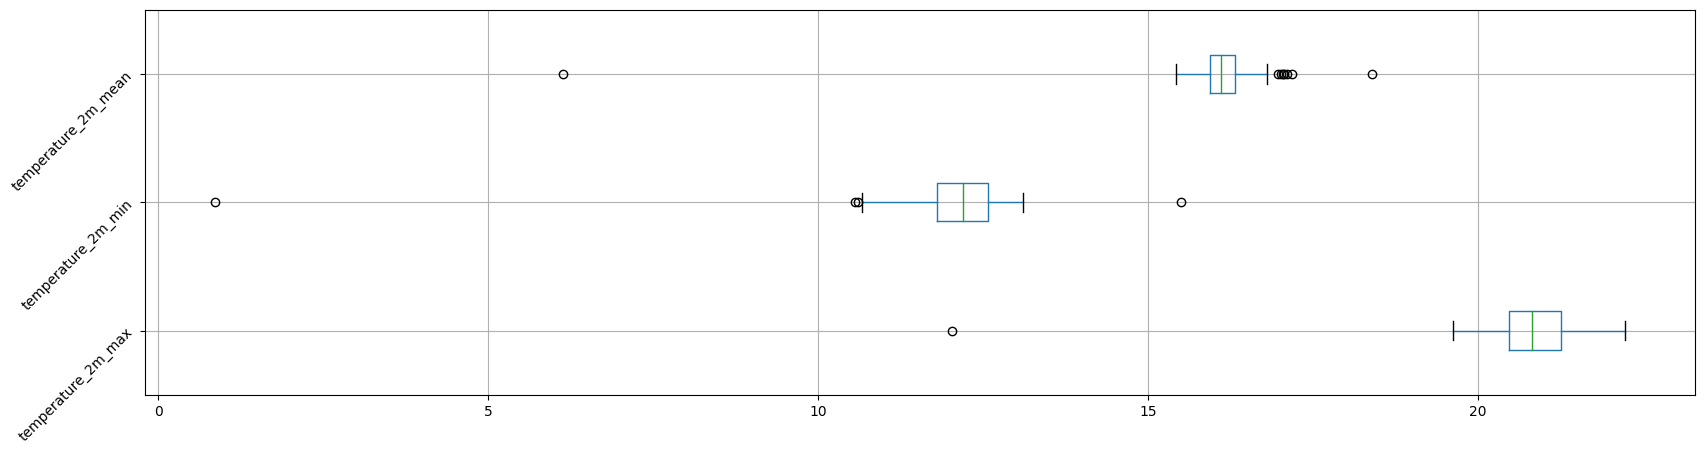

In [ ]:
_data.boxplot(column=['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean'], rot=45, figsize=(20,5), vert=False)

## Standard Deviation

In [ ]:
display(_weather_daily_explode_dataframe.drop(["sunrise", "sunset"], axis = 1).groupby(['time']).std(ddof=0))

,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
time,,,,,,,,,,,,,,,,
2000-06-17,27.341462,8.843956,8.363412,8.206095,12.913043,11.501981,11.866292,2.471167,2.471167,0.000000,4.546061,5.648205,3.681787,70.551793,4.668914,1.001477
2002-12-24,25.694790,1.649916,2.106076,1.327487,2.217105,2.222611,2.145279,0.518545,0.518545,0.000000,0.942809,4.881484,13.893484,110.998498,0.731574,0.332298
2014-04-13,21.742757,7.027524,6.773321,6.773217,9.129013,9.061793,9.038212,3.219410,3.220446,0.015256,6.479969,4.063284,6.465787,80.153852,3.187903,0.876869
2014-04-14,25.974988,7.236261,7.004632,6.896818,9.493275,9.347506,9.229334,3.638526,3.631129,0.015256,6.747407,6.102399,6.837724,101.306700,3.318892,0.940208
2014-04-15,24.067561,7.028618,7.122112,6.866986,9.285828,9.618122,9.336777,5.689763,5.689763,0.000000,6.692346,7.246273,11.566887,106.757424,3.430737,0.769750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-23,27.254862,6.772184,7.042187,6.845247,9.287350,9.516880,9.345132,2.531423,2.514254,0.228548,4.848711,6.155729,7.833676,104.608926,3.335570,0.788708
2014-09-24,24.458690,6.703216,6.969467,6.674539,9.304456,9.354372,9.064926,3.137591,3.136144,0.045768,5.043808,3.156782,5.308898,112.083217,4.158441,0.962602
2014-09-25,28.389082,6.697408,6.893120,6.654493,8.847558,8.958633,8.827010,2.425984,2.408791,0.077000,6.399023,3.846375,4.932471,112.564248,4.128493,0.990568


from matplotlib import pyplot as plt
_df_16['weathercode'].plot(kind='hist', bins=20, title='weathercode')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17['temperature_2m_max'].plot(kind='hist', bins=20, title='temperature_2m_max')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18['temperature_2m_min'].plot(kind='hist', bins=20, title='temperature_2m_min')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19['temperature_2m_mean'].plot(kind='hist', bins=20, title='temperature_2m_mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20.plot(kind='scatter', x='weathercode', y='temperature_2m_max', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21.plot(kind='scatter', x='temperature_2m_max', y='temperature_2m_min', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22.plot(kind='scatter', x='temperature_2m_min', y='temperature_2m_mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23.plot(kind='scatter', x='temperature_2m_mean', y='apparent_temperature_max', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_24['weathercode'].plot(kind='line', figsize=(8, 4), title='weathercode')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_25['temperature_2m_max'].plot(kind='line', figsize=(8, 4), title='temperature_2m_max')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_26['temperature_2m_min'].plot(kind='line', figsize=(8, 4), title='temperature_2m_min')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_27['temperature_2m_mean'].plot(kind='line', figsize=(8, 4), title='temperature_2m_mean')
plt.gca().spines[['top', 'right']].set_visible(False)

### Data visualization with processing

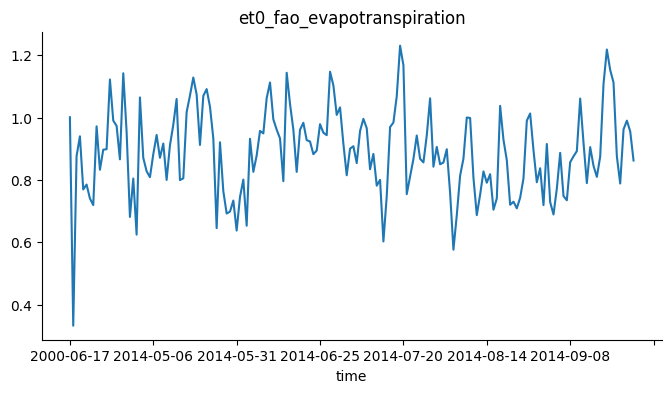

In [ ]:
_df_24['et0_fao_evapotranspiration'].plot(kind='line', figsize=(8, 4), title='et0_fao_evapotranspiration')
plt.gca().spines[['top', 'right']].set_visible(False)

## Mean

In [ ]:
display(_weather_daily_explode_dataframe.drop(["sunrise", "sunset"], axis = 1).groupby(['time']).mean())

,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
time,,,,,,,,,,,,,,,,
2000-06-17,41.666667,21.833333,15.500000,18.400000,23.800000,16.366667,19.633333,3.400000,3.400000,0.0000,5.000000,14.366667,33.866667,81.666667,13.103333,2.653333
2002-12-24,18.666667,12.033333,0.866667,6.133333,9.033333,-2.800000,2.933333,0.366667,0.366667,0.0000,0.666667,16.233333,40.566667,109.000000,14.370000,2.096667
2014-04-13,44.050000,20.630000,12.875000,16.305000,22.525000,13.230000,16.935000,2.420000,2.415000,0.0035,6.900000,10.765000,31.660000,105.600000,19.534500,3.532500
2014-04-14,41.000000,20.655000,13.025000,16.370000,22.435000,13.375000,17.020000,3.175000,3.170000,0.0035,6.850000,11.565000,32.095000,161.950000,19.145000,3.527000
2014-04-15,43.550000,20.005000,13.005000,15.950000,21.320000,13.185000,16.460000,4.060000,4.060000,0.0000,7.250000,12.495000,34.175000,143.550000,18.145000,3.304500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-23,38.350000,20.405000,12.560000,15.840000,21.475000,12.300000,15.850000,2.170000,2.095000,0.0560,4.700000,12.100000,33.605000,208.150000,21.534000,3.913000
2014-09-24,38.850000,20.530000,12.755000,16.095000,21.590000,12.635000,16.175000,2.255000,2.240000,0.0105,5.400000,11.615000,32.360000,163.550000,20.489500,3.766500
2014-09-25,36.400000,21.065000,12.530000,16.285000,22.435000,12.170000,16.370000,2.040000,2.015000,0.0210,5.050000,11.380000,32.265000,191.300000,21.634500,3.976000


from matplotlib import pyplot as plt
_df_28['weathercode'].plot(kind='hist', bins=20, title='weathercode')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_29['temperature_2m_max'].plot(kind='hist', bins=20, title='temperature_2m_max')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_30['temperature_2m_min'].plot(kind='hist', bins=20, title='temperature_2m_min')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_31['temperature_2m_mean'].plot(kind='hist', bins=20, title='temperature_2m_mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_32.plot(kind='scatter', x='weathercode', y='temperature_2m_max', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_33.plot(kind='scatter', x='temperature_2m_max', y='temperature_2m_min', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_34.plot(kind='scatter', x='temperature_2m_min', y='temperature_2m_mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_35.plot(kind='scatter', x='temperature_2m_mean', y='apparent_temperature_max', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_36['weathercode'].plot(kind='line', figsize=(8, 4), title='weathercode')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_37['temperature_2m_max'].plot(kind='line', figsize=(8, 4), title='temperature_2m_max')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_38['temperature_2m_min'].plot(kind='line', figsize=(8, 4), title='temperature_2m_min')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_39['temperature_2m_mean'].plot(kind='line', figsize=(8, 4), title='temperature_2m_mean')
plt.gca().spines[['top', 'right']].set_visible(False)

### Data visualization with processing

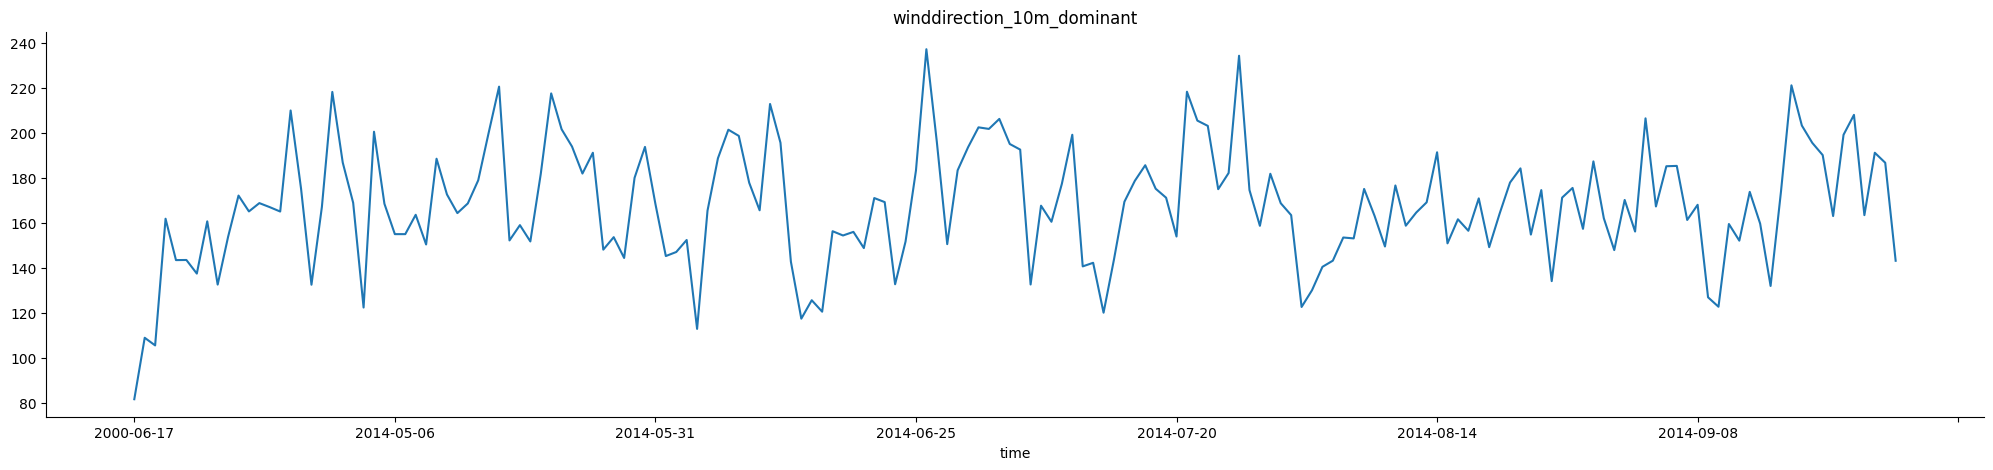

In [ ]:
from matplotlib import pyplot as plt
_df_36['winddirection_10m_dominant'].plot(kind='line', figsize=(25, 5), title='winddirection_10m_dominant')
plt.gca().spines[['top', 'right']].set_visible(False)

## Median

In [ ]:
display(_weather_daily_explode_dataframe.drop(["sunrise", "sunset"], axis = 1).groupby(['time']).median())

,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
time,,,,,,,,,,,,,,,,
2000-06-17,61.0,26.20,19.30,22.80,31.60,22.20,26.90,4.40,4.40,0.0,4.0,17.10,34.20,56.0,15.850,3.130
2002-12-24,1.0,13.20,1.60,6.70,10.50,-1.70,4.40,0.00,0.00,0.0,0.0,18.80,36.00,53.0,14.010,2.010
2014-04-13,51.0,21.30,11.65,16.15,22.75,11.35,16.45,0.55,0.55,0.0,3.5,10.40,30.75,83.5,20.520,3.550
2014-04-14,53.0,20.50,12.65,15.65,21.65,12.25,15.80,1.95,1.95,0.0,4.5,10.20,30.60,191.0,19.675,3.420
2014-04-15,54.0,19.75,12.30,15.85,21.10,12.00,15.75,2.15,2.15,0.0,6.5,9.90,31.30,172.0,18.060,3.335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-23,53.0,20.30,12.35,15.65,20.65,12.10,15.05,1.40,1.40,0.0,3.0,10.40,32.05,211.5,22.070,3.775
2014-09-24,51.0,19.80,12.30,15.70,20.60,10.85,15.15,1.35,1.35,0.0,5.0,11.85,31.85,189.0,21.365,3.560
2014-09-25,51.0,21.15,13.05,16.55,20.85,11.45,15.85,0.95,0.95,0.0,2.0,10.90,31.85,205.0,22.190,3.885


from matplotlib import pyplot as plt
_df_0['weathercode'].plot(kind='hist', bins=20, title='weathercode')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['temperature_2m_max'].plot(kind='hist', bins=20, title='temperature_2m_max')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['temperature_2m_min'].plot(kind='hist', bins=20, title='temperature_2m_min')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['temperature_2m_mean'].plot(kind='hist', bins=20, title='temperature_2m_mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='weathercode', y='temperature_2m_max', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='temperature_2m_max', y='temperature_2m_min', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='temperature_2m_min', y='temperature_2m_mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='temperature_2m_mean', y='apparent_temperature_max', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['snowfall_sum']
  ys = series['weathercode']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('snowfall_sum', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('snowfall_sum')
_ = plt.ylabel('weathercode')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['snowfall_sum']
  ys = series['temperature_2m_max']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('snowfall_sum', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('snowfall_sum')
_ = plt.ylabel('temperature_2m_max')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['snowfall_sum']
  ys = series['temperature_2m_min']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('snowfall_sum', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('snowfall_sum')
_ = plt.ylabel('temperature_2m_min')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['snowfall_sum']
  ys = series['temperature_2m_mean']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('snowfall_sum', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('snowfall_sum')
_ = plt.ylabel('temperature_2m_mean')

from matplotlib import pyplot as plt
_df_12['weathercode'].plot(kind='line', figsize=(8, 4), title='weathercode')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['temperature_2m_max'].plot(kind='line', figsize=(8, 4), title='temperature_2m_max')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['temperature_2m_min'].plot(kind='line', figsize=(8, 4), title='temperature_2m_min')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['temperature_2m_mean'].plot(kind='line', figsize=(8, 4), title='temperature_2m_mean')
plt.gca().spines[['top', 'right']].set_visible(False)

### Data visualization with processing

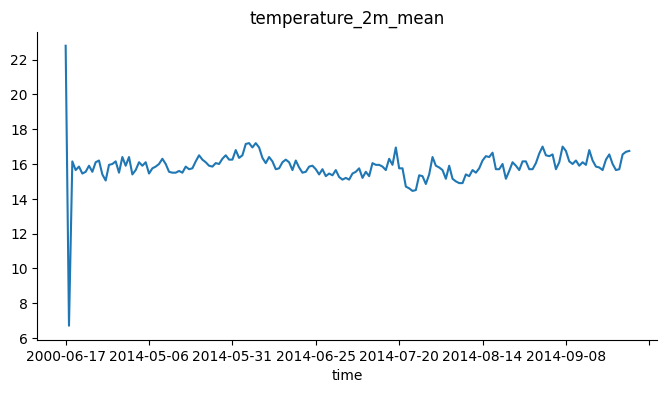

In [ ]:
_df_15['temperature_2m_mean'].plot(kind='line', figsize=(8, 4), title='temperature_2m_mean')
plt.gca().spines[['top', 'right']].set_visible(False)